<a href="https://colab.research.google.com/github/AnouarSeg/Alyn/blob/master/TP_Gaussian_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master PSL IASD - Advanced Machine Learning - Gaussian Process

# Introduction

In supervised learning, we often use parametric models $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ to explain data and infer optimal values of parameter $\boldsymbol\theta$ via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) or [maximum a posteriori](https://de.wikipedia.org/wiki/Maximum_a_posteriori) estimation. If needed, we can also infer a full [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) $p(\boldsymbol\theta \lvert \mathbf{X},\mathbf{y})$ instead of a point estimate $\boldsymbol{\hat\theta}$. 

One example of non-parametric methods are [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). Instead of inferring a distribution over the parameters of a parametric estimate function, Gaussian Processes can be used to infer a distribution over functions directly. A Gaussian Process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions. Inference of continuous function values in this context is known as GP regression, however GPs can also be used for classification.

A Gaussian Process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) for which any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and for which the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{1}\label{eq1}$$

In Equation $(1)$, $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. $m$ is the mean function and it is common to use $m(\mathbf{x}) = 0$ as GPs are flexible enough to model the mean arbitrarily well. $\kappa$ is a positive semi definite *kernel function* or *covariance function*. Thus, a Gaussian Process is a distribution over functions whose shape (smoothness, ...) is defined by $\mathbf{K}$. If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too. 

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}\label{eq2}
\end{align*}
$$

Equation $(2)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}\label{eq3}
$$

With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{5}\label{eq5}
\end{align*}
$$

This is the minimum we need to know for implementing Gaussian processes and applying them to regression problems. For further details, please consult the literature in the [References](#References) section. The next section shows how to implement GPs with plain NumPy from scratch, later sections demonstrate how to use GP implementations from [Scikit-Learn](http://scikit-learn.org/stable/) and [TensorFlow Probability](https://www.tensorflow.org/probability/). You can also find another [TensorFlow](https://www.tensorflow.org/)-based implementation of GPs with [GPflow](https://github.com/GPflow/GPflow), and its NumPy version with [GPy](http://sheffieldml.github.io/GPy/).

In [0]:
%matplotlib inline

import os
import sklearn
import warnings

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# I. Gaussian Process with NumPy


### Kernels

*Question : Fill the blanks to implement following kernels*
- *Gaussian (RBF) Kernel*
\begin{equation}
    \kappa(\textbf{x}_i, \textbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2} || \textbf{x}_i - \textbf{x}_j ||^2)
\end{equation}

- *Rational Quadratic Kernel*
\begin{equation}
    \kappa(\textbf{x}_i, \textbf{x}_j) = (1 + \frac{|| \textbf{x}_i - \textbf{x}_j ||^2}{2 \alpha l^2})^{-\alpha}, \alpha \ge 0
\end{equation}


*You can use the identity below :*
\begin{equation}
    || \textbf{x} - \textbf{y} ||^2 = || \textbf{x} ||^2 + || \textbf{y} ||^2 - 2 < \textbf{x}, \textbf{y} > = || \textbf{x} ||^2 + || \textbf{y} ||^2 - 2 \textbf{x}^T\textbf{y}
\end{equation}

In [0]:
class Gaussian_Kernel(object) :
    
    """ Isotropic squared exponential kernel.
    
    Parameters
    ----------
    X1 : numpy array
        Array of m points (m x d).
             
    X2 : numpy array
        Array of n points (n x d).
         
    """
    
    def __init__(self, length_scale = 1.0, sigma_f = 1.0) :
        
        self.length_scale = length_scale
        self.sigma_f = sigma_f
        
    def __call__(self, X1, X2 = None) :
        
        """ Computes a covariance matrix from points in X1 and X2. 
        
        Parameters
        ----------
        X1 : numpy array
            Array of m points (m x d).
             
        X2 : numpy array
            Array of n points (n x d).
             
        Returns
        -------
        K : numpy array
            Covariance matrix (m x n).
        
        """
        
        if X2 is None : # Reminder : in practice, X1 = X2 !
            
            X2 = X1
        
        #### FILL THE BLANK ####
        #### FILL THE BLANK ####
    
        return K

In [0]:
class RationalQuadratic_Kernel(object) :
    
    """ Rational Quadratic kernel.
    
    Parameters
    ----------
    X1 : numpy array
        Array of m points (m x d).
             
    X2 : numpy array
        Array of n points (n x d).
         
    """
    
    def __init__(self, length_scale = 1.0, alpha = 1.0) :
        
        self.length_scale = length_scale
        self.alpha = alpha
        
    def __call__(self, X1, X2 = None) :
        
        """ Computes a covariance matrix from points in X1 and X2. 
        
        Parameters
        ----------
        X1 : numpy array
            Array of m points (m x d).
             
        X2 : numpy array
            Array of n points (n x d).
             
        Returns
        -------
        K : numpy array
            Covariance matrix (m x n).
        
        """
        
        if X2 is None : # Reminder : in practice, X1 = X2 !
            
            X2 = X1
        
        #### FILL THE BLANK ####
        #### FILL THE BLANK ####
    
        return K

### Prior

Let's first define a prior over functions with mean zero and a covariance matrix computed with Gaussian kernel default parameters. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

In [0]:
def plot_GaussianProcess(mu, cov, X, X_train = None, Y_train = None, samples = []) :
    
    X = X.ravel()
    mu = mu.ravel()
    
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha = 0.1)
    plt.plot(X, mu, label = 'Mean')
    
    for i, sample in enumerate(samples) :
        plt.plot(X, sample, lw = 1, ls = '--', label = 'Sample {}'.format(i+1))
        
    if X_train is not None :
        plt.plot(X_train, Y_train, 'rx')
        
    plt.legend()

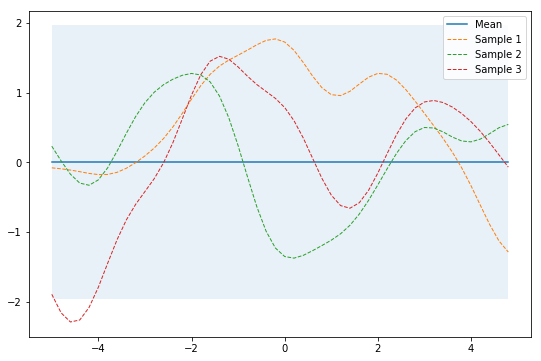

In [0]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
kernel = Gaussian_Kernel()
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plt.figure(figsize = (9, 6))
plot_GaussianProcess(mu, cov, X, samples = samples)

### Posterior Predictive Distribution

*Question : Define a function which returns the sufficient statistics i.e. mean and covariance of the GP posterior predictive distribution based on a chosen kernel, input and output training data and new inputs, according to Equations $(4)$ and $(5)$.*

In [0]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, kernel = Gaussian_Kernel(), sigma_y = 1e-8) :
    
    """ Computes the sufficient statistics of the GP posterior predictive distribution 
        from a chosen kernel, m training data X_train and Y_train and n new inputs X_s.
    
    Parameters
    ----------
    X_s : numpy array
        New input locations (n x d).
    
    X_train : numpy array
        Training locations (m x d).
    
    Y_train : numpy array
        Training targets (m x 1).
    
    kernel : callable kernel object
        Kernel.
    
    sigma_y : float
        Noise parameter.
    
    Returns
    -------
    mu_s : numpy array
        Posterior mean vector (n x d).
           
    cov_s : numpy array
        Covariance matrix (n x n).
        
    """
    
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    K_s = #### FILL THE BLANK ####
    K_ss = kernel(X_s, X_s) + 1e-8 * np.eye(len(X_s))
    K_inv = #### FILL THE BLANK ####
    
    # Equation (4)
    mu_s = #### FILL THE BLANK ####

    # Equation (5)
    cov_s = #### FILL THE BLANK ####
    
    return mu_s, cov_s

### Prediction from noise-free training data
*Question : Compute and plot sufficient statistics of the GP posterior predictive distribution for* `X_train`, `Y_train` *and new inputs* `X` *for both Gaussian and Rational Quadratic kernels.*

With Gaussian Kernel

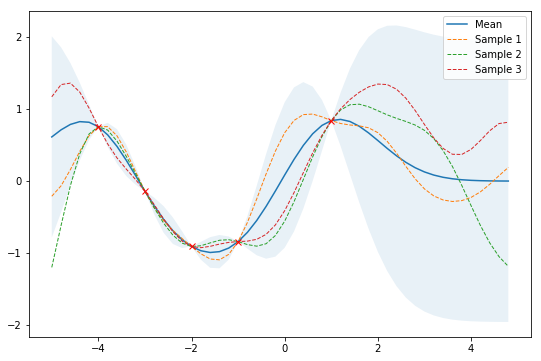

In [0]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = #### FILL THE BLANK ####

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

With Rational Quadratic kernel

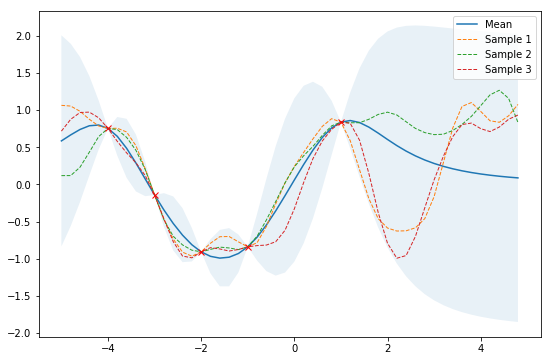

In [0]:
# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = #### FILL THE BLANK ####

samples = #### FILL THE BLANK ####

plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

### Prediction from noisy training data
*Question : Compute and plot sufficient statistics of the GP posterior predictive distribution for* `X_train`, `Y_train` *and new inputs* `X` *for both Gaussian and Rational Quadratic kernels.*

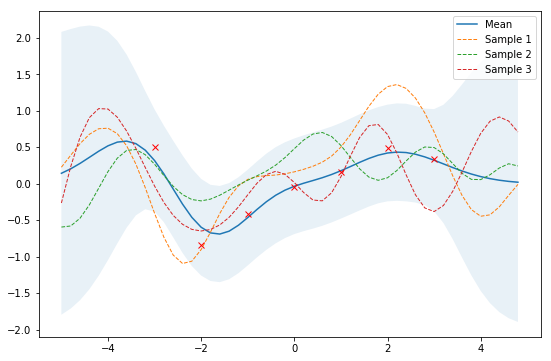

In [0]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = #### FILL THE BLANK ####

samples = #### FILL THE BLANK ####

plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

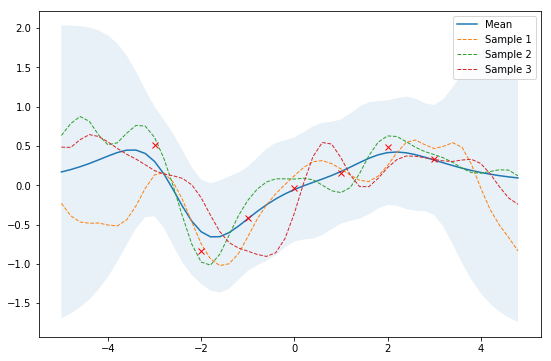

In [0]:
# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = #### FILL THE BLANK ####

samples = #### FILL THE BLANK ####

plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

### Effect of kernel parameters and noise parameter

*Question : What are effects of kernel parameters and noise parameter ? Find relevant hyperparameters ranges and try for both kernels !*

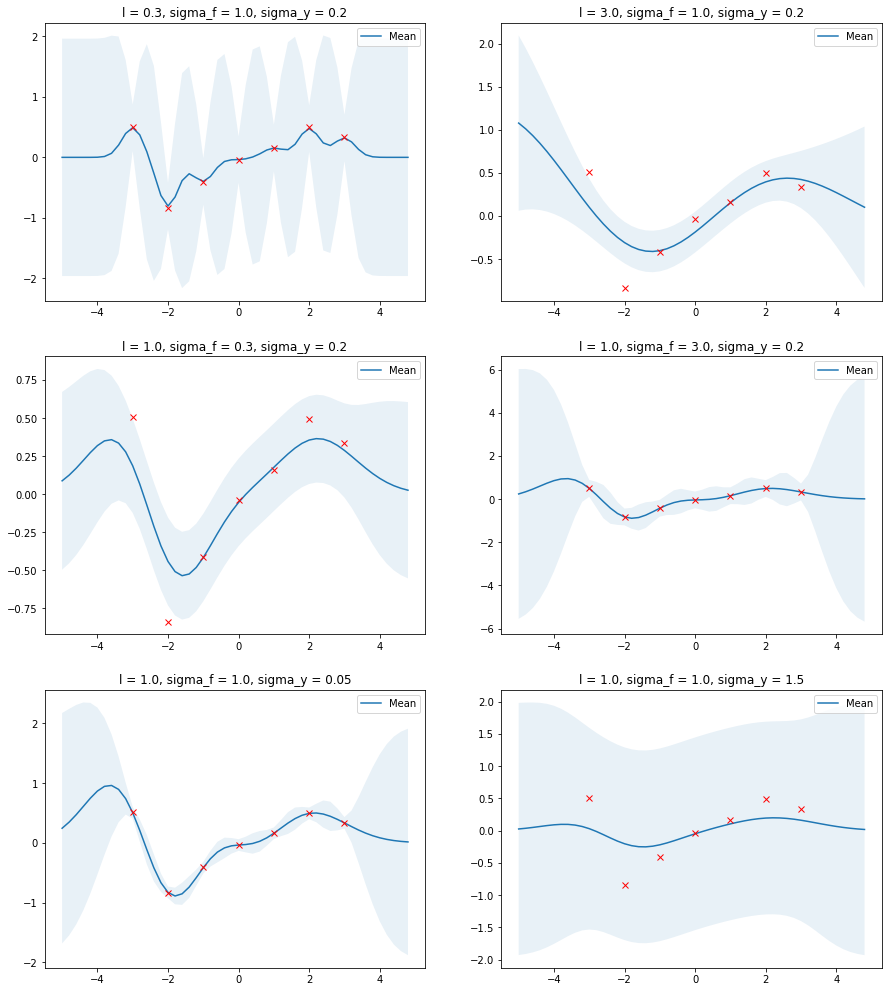

In [0]:
gaussian_params = [
        (0.3, 1.0, 0.2),
        (3.0, 1.0, 0.2),
        (1.0, 0.3, 0.2),
        (1.0, 3.0, 0.2),
        (1.0, 1.0, 0.05),
        (1.0, 1.0, 1.5),
]

plt.figure(figsize = (15, 7))

for i, (l, sigma_f, sigma_y) in enumerate(gaussian_params) :
    
    mu_s, cov_s = #### FILL THE BLANK ####
                                       
    
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top = 2)
    plt.title('l = {}, sigma_f = {}, sigma_y = {}'.format(l, sigma_f, sigma_y))
    # plot #### FILL THE BLANK ####

### Negative log-likelihood Minimization

Optimal values of kernel parameters, $l$ and $\sigma_f$ for Gaussian Kernel for instance, can be estimated by maximizing the log marginal likelihood which is given by<sup>[1][3]</sup>

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{6}
$$

where $|.|$ is determinant.

*Question : define a* `class` *which computes the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$ ($\alpha$ for Rational Quadratic kernel). Precisely, be careful to `nll_stable` method to implement `nll_naive` from Equation $(6)$ !* 

In [0]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize


class Negative_Log_Likelihood(object) :
    
    """ Returns the negative log marginal likelihood for training data X_train 
        and Y_train and given noise level.
        
    """
    
    def __init__(self, X_train, Y_train, noise, kernel = 'gaussian', naive = True) :
        
        """
        
        Parameters
        ----------
        X_train : numpy array
            Training locations (m x d).

        Y_train : numpy array
            Training targets (m x 1).

        kernel : 'gaussian' or 'rational quadratic'
            Kernel.

        noise : float
            Known noise level of Y_train.

        naive : bool
            If True use a naive implementation of Eq. (6), if False use a numerically more stable implementation. 
        
        """
        
        self.X_train = X_train
        self.Y_train = Y_train
        
        if kernel == 'gaussian' :
            self.kernel = Gaussian_Kernel
        
        elif kernel == 'rational quadratic':
            self.kernel = RationalQuadratic_Kernel
        
        else :
            raise ValueError("kernel must be in ['gaussian', 'rational quadratic']") 
            # You are free to implement and take into account more kernels and adapt this negative log likelihood implementation
            
        self.noise = noise
        self.naive = naive
    
    
    def __call__(self, theta) :
        
        #### FILL THE BLANK ####
        # if naive :
        #     -> nll_naive computing method
        # else :
        #     -> nll_stable computing method
    
    
    def nll_naive(self, theta) :
        
        """ Naive implementation of Eq. (6). 
        
        Returns
        -------
            Minimization objective.
            
        """
        
        K = self.kernel(theta[0], theta[1])(self.X_train, self.X_train) + self.noise**2 * np.eye(len(self.X_train))
        
        return #### FILL THE BLANK ####
    
    def nll_stable(self, theta) :
        
        """ Numerically more stable implementation of Eq. (6). 
        
        Returns
        -------
            Minimization objective.
            
        """
        
        K = self.kernel(theta[0], theta[1])(self.X_train, self.X_train) + self.noise**2 * np.eye(len(self.X_train))
        L = cholesky(K)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * self.Y_train.T.dot(lstsq(L.T, lstsq(L, self.Y_train)[0])[0]) + \
               0.5 * len(self.X_train) * np.log(2*np.pi)


*Then, compute the negative log marginal likelihood of previously declared* `X_train`, `Y_train` *and* `noise`, *with Gaussian Kernel and default parameters.*

In [0]:
#### FILL THE BLANK ####

array([[6.84519561]])

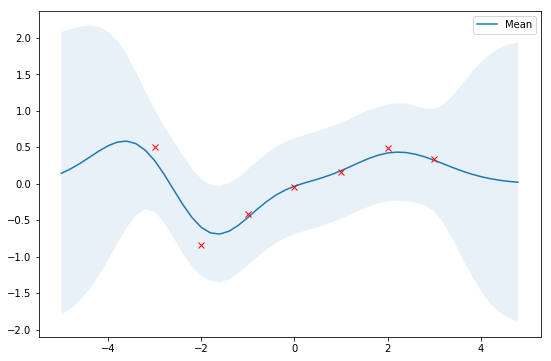

In [0]:
# Compute the prosterior predictive statistics with default kernel parameters and plot the results

mu_s, cov_s = posterior_predictive(X, X_train, Y_train, kernel = Gaussian_Kernel(length_scale = 1., sigma_f = 1.), sigma_y = noise)

plt.figure(figsize = (9, 6))
plot_GaussianProcess(mu_s, cov_s, X, X_train = X_train, Y_train = Y_train)

*Question : use* [L-BFGS Method](https://en.wikipedia.org/wiki/Limited-memory_BFGS) *to minimize negative log marginal likelihood and compare (plot) results with default parameters !*

In [0]:
res = minimize(Negative_Log_Likelihood(X_train, Y_train, noise, naive = False), 
               x0 = [1., 1.], 
               bounds = ((1e-5, None), (1e-5, None)),
               method = 'L-BFGS-B')

# In practice, you have to experiments different initial kernel hyperparameters values to find the best !

# Store the optimization results to compare them with initial parameters [1., 1.]
l_opt, sigma_f_opt = res.x

print(#### FILL THE BLANK ####)
print(#### FILL THE BLANK ####)

1.6451186349492608 0.19496729217267122
[[4.66207723]]


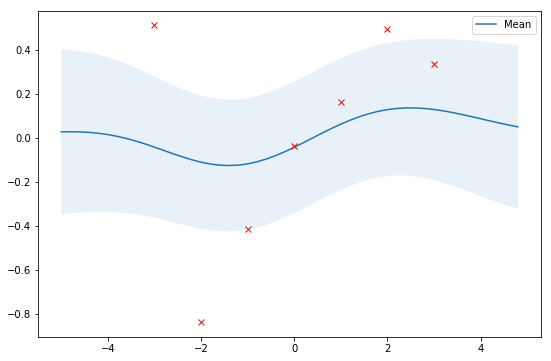

In [0]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results

mu_s, cov_s = #### FILL THE BLANK ####

plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

*Question : Try the same with Rational Quadratic kernel !*

# II. Gaussian Process with Scikit-Learn

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

*Question : Define a GaussianProcessRegressor for the declared kernel, train the model on* `X_train` *and* `Y_train` *then predict mean and covariance from new inputs* `X` *! Once fitted, compare returned mean and covariance with* `l_opt` *and* `sigma_f_opt`*, then plot the corresponding Gaussian Process !*

Negative Log Marginal Likelihood : 4.514893507545349
l_opt : 1.6451186349492608 | l : 0.783764473251157
sigma_f_opt : 0.19496729217267122 | sigma_f : 0.2457578952226333


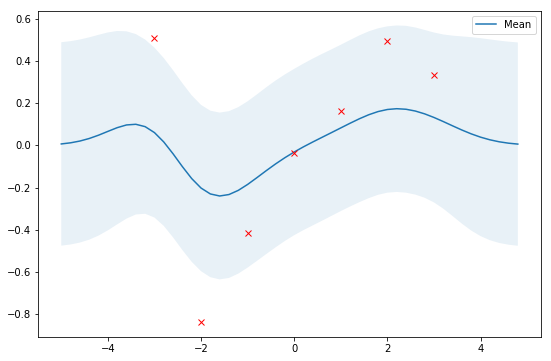

In [0]:
rbf = ConstantKernel(1.0) * RBF(length_scale = 1.0)
gpr = GaussianProcessRegressor(kernel = rbf, alpha = noise**2, n_restarts_optimizer = 50) #### FILL THE BLANK ####

# Reuse training data from previous example
# Fit #### FILL THE BLANK ####

# Compute posterior predictive mean and covariance
# Predict #### FILL THE BLANK ####

# Obtain optimized kernel parameters
l = #### FILL THE BLANK ####
sigma_f = #### FILL THE BLANK ####

# Compare with previous results
print('Negative Log Marginal Likelihood : {}'.format(-gpr.log_marginal_likelihood()))
print('l_opt : {} | l : {}'.format(l_opt, l))
print('sigma_f_opt : {} | sigma_f : {}'.format(sigma_f_opt, sigma_f))

# Plot the results
plt.figure(figsize = (9, 6))
# plot #### FILL THE BLANK ####

# III. Gaussian Process with TensorFlow

In [0]:
import tensorflow_probability as tfp

tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

### 1). The simple case

In [0]:
X_train = np.array([-4., -3., -2., -1., 1.]).reshape(-1, 1)
Y_train = np.sin(X_train[..., 0])

print(X_train.shape)
print(Y_train.shape)

(5, 1)
(5,)


Define Gaussian kernel hyperparameters variables

In [0]:
amplitude = tf.Variable(initial_value = 1., name = 'amplitude', dtype = np.float64)
length_scale = tf.Variable(initial_value = 1., name = 'length_scale', dtype = np.float64)

*Question : Define a training loop to fit Gaussian Process on* `X_train` *and* `Y_train` *trying different hyperparameters values.*

In [0]:
optimizer = tf.optimizers.Adam(## Try different hyperparameters)

n_iter = ## Try different numbers of iterations
losses = []

for i in range(n_iter) :
    
    with tf.GradientTape() as tape :
        
        kernel = psd_kernels.ExponentiatedQuadratic(amplitude = amplitude,
                                                    length_scale = length_scale)
        gp = tfd.GaussianProcess(kernel = kernel,
                                 index_points = X_train,
                                 observation_noise_variance = 0.4)
        loss = -gp.log_prob(Y_train)
    
    gradient = tape.gradient(loss, gp.trainable_variables)
    optimizer.apply_gradients(zip(gradient, gp.trainable_variables))
    
    losses.append(loss.numpy())
    
    print('=============== Iteration {} ===============\n'.format(i))
    
    print('\tNegative log likelihood : {}'.format(loss.numpy()))
    
    for j in range(len(gp.trainable_variables)) :
        print('\t{} : {}'.format(gp.trainable_variables[j].name, gp.trainable_variables[j].numpy()))
    
    print('\n')

=============== Iteration 0 ===============

	Negative log likelihood : 6.035121057233803
	amplitude:0 : 0.9900000180977953
	length_scale:0 : 1.0099999375807442


=============== Iteration 1 ===============

	Negative log likelihood : 6.01261884247179
	amplitude:0 : 0.9800044210130532
	length_scale:0 : 1.019981588049834


=============== Iteration 2 ===============

	Negative log likelihood : 5.990686488544401
	amplitude:0 : 0.97001638736446
	length_scale:0 : 1.0299309334034639


=============== Iteration 3 ===============

	Negative log likelihood : 5.969342272235543
	amplitude:0 : 0.9600392782015152
	length_scale:0 : 1.0398325066446077


=============== Iteration 4 ===============

	Negative log likelihood : 5.948603017060235
	amplitude:0 : 0.9500766348857511
	length_scale:0 : 1.049669307993688


=============== Iteration 5 ===============

	Negative log likelihood : 5.928483894946812
	amplitude:0 : 0.9401321742899884
	length_scale:0 : 1.0594227303101307


=============== Iteration 6

### 2). A more sophisticated case

In [0]:
def f(x) :
    
    """ Function to estimate.
    """
    
    # Squeeze to take the shape from [num_points, 1] to [num_points] -> x[..., 0]
    
    return np.sin(x[..., 0]) # np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2) 

In [0]:
num_points = 100

observed_index_points = np.expand_dims(np.random.uniform(-1., 1., num_points), -1)
print(observed_index_points.shape)

observed_values = f(observed_index_points)
print(observed_values.shape)

(100, 1)
(100,)


*Question : plot data* `observed_index_points` *and* `observed_values`. 

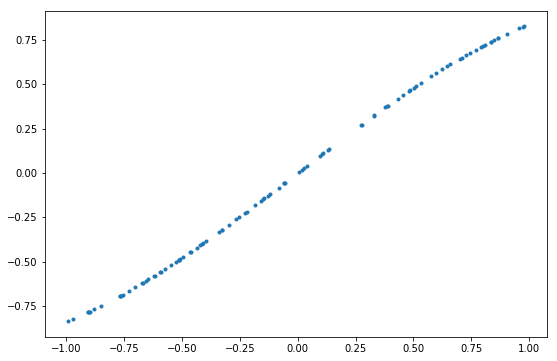

In [0]:
#### FILL THE BLANK ####
#### FILL THE BLANK ####

*Question : Define Gaussian kernel hyperparameters variables.*

In [0]:
# Amplitude #### FILL THE BLANK ####
# Length scale #### FILL THE BLANK ####

*Question : Define a training loop to fit Gaussian Process on* `observed_index_points` *and* `observed_values`.

In [0]:
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####
#### FILL THE BLANK ####

=============== Iteration 0 ===============

	Negative log likelihood : 52.64919857931792
	amplitude:0 : 0.990000017286968
	length_scale:0 : 1.0099999855935904


=============== Iteration 1 ===============

	Negative log likelihood : 52.60903569541871
	amplitude:0 : 0.9800068735281466
	length_scale:0 : 1.0199870661002512


=============== Iteration 2 ===============

	Negative log likelihood : 52.57025540344591
	amplitude:0 : 0.9700258796869554
	length_scale:0 : 1.0299519384218765


=============== Iteration 3 ===============

	Negative log likelihood : 52.53289968509114
	amplitude:0 : 0.9600629831295783
	length_scale:0 : 1.0398847640810458


=============== Iteration 4 ===============

	Negative log likelihood : 52.49700999242751
	amplitude:0 : 0.9501248403609007
	length_scale:0 : 1.0497751579408348


=============== Iteration 5 ===============

	Negative log likelihood : 52.462626929099834
	amplitude:0 : 0.9402188961079221
	length_scale:0 : 1.0596121802190221


=============== Iterat

### 3). To go further : Application to Reinforcement Learning

A TensorFlow-like framework is very convenient to adress sequential learning problem due to automatic differentiation.

[Probabilistic Inference for Learning Control (PILCO)](http://mlg.eng.cam.ac.uk/pub/pdf/DeiRas11.pdf) is a model-based Reinforcement Learning algorithm which adresses [Cart-Pole swing-up](https://gym.openai.com/envs/CartPole-v1/), for instance. [Here](http://mlg.eng.cam.ac.uk/pilco/), you can see experiments on PILCO website, and [here](https://www.cs.toronto.edu/~duvenaud/courses/csc2541/slides/pilco.pdf) another reference for PILCO algorithm.

We consider following dynamic systems :
\begin{equation}
    x_t = f(x_{t-1}, u_{t-1})
\end{equation}

with continuous-valued states $x \in \mathbf{R}^D$, controls $u \in \mathbf{R}^F$ and unknown transition dynamics $f$. The objective is to find a deterministic policy/controller $\pi : \mathbf{x} \rightarrow \pi(\mathbf{x}) = u$ that minimizes the *expected return* :
\begin{equation}
    J^{\pi}(\theta) = \Sigma_{t = 0}^T \mathbf{E}_{\mathbf{x_t}}(c(\mathbf{x_t}))
\end{equation}

of following $\pi$ for $T$ steps, where $c(\mathbf{x_t})$ is the cost (negative reward) of being in a state $\mathbf{x}$ at time $t$. The policy $\pi$ is parametrized by $\theta$, $\mathbf{u} = \pi(\mathbf{x}, \theta)$, and the cost function $c$ has to encode some information about a target state $\mathbf{x}_{target}$, for instance :
\begin{equation}
    c(\mathbf{x}) = 1 - \exp(-\frac{||\mathbf{x} - \mathbf{x}_{target}||^2}{\sigma_c^2})
\end{equation}

**PILCO :**

$1.$ **init :** *sample controller parameters* $\theta$ ~ $\mathcal{N}(0, \mathbf{I})$ <br>
*Apply random control signals and record data.* <br>

$2.$ **repeat**
1. Learn probabilistic (GP) dynamics model using all data.
2. Model based policy search :
3. **repeat**
    * Approximate inference for policy evaluation : get $J^{\pi}(\theta)$
    * Gradient-based policy improvement : get $\frac{d J^{\pi}(\theta)}{d \theta}$
    * Update parameters $\theta$ (L-BFGS, SGD...)
4. **until** convergence; return $\theta$*.
5. Set $\pi$* $\leftarrow \pi(\theta$*$)$.
6. Apply $\pi$* to system (single trial/episode) and record data.

$3.$ **until** task learned.

*Challenge : Once you have done this practical session and learned to handle Gaussian Processes, implement PILCO algorithm !*


Note also that [OpenAI Gym](https://gym.openai.com/) is a reference tool to interact with environments for RL algorithms implementation !

In [0]:
import gym

In [0]:
env = gym.make('CartPole-v1')

In [0]:
for i_episode in range(10) :
    
    observation = env.reset()
    
    for _ in range(10):
        
        env.render()
        print(observation)
        
        action = env.action_space.sample()
        print('Action : {}'.format(action))
        
        observation, reward, done, info = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(_+1))
            break
            
env.close()

[ 0.00428218 -0.03760074 -0.00320996 -0.02225941]
Action : 1
[ 0.00353016  0.15756709 -0.00365515 -0.31595339]
Action : 0
[ 0.00668151 -0.0375026  -0.00997422 -0.02442541]
Action : 1
[ 0.00593145  0.15776096 -0.01046273 -0.32023855]
Action : 1
[ 0.00908667  0.35303034 -0.0168675  -0.61620258]
Action : 0
[ 0.01614728  0.15814805 -0.02919155 -0.32887954]
Action : 1
[ 0.01931024  0.35367315 -0.03576914 -0.63062333]
Action : 1
[ 0.0263837   0.54927547 -0.04838161 -0.93435302]
Action : 0
[ 0.03736921  0.35483838 -0.06706867 -0.65725732]
Action : 0
[ 0.04446598  0.16071096 -0.08021382 -0.38642427]
Action : 0
[ 0.01937943 -0.03899246 -0.02159514 -0.02851481]
Action : 0
[ 0.01859958 -0.23379817 -0.02216543  0.25727714]
Action : 1
[ 0.01392362 -0.03836689 -0.01701989 -0.04231386]
Action : 1
[ 0.01315628  0.15699493 -0.01786617 -0.34031776]
Action : 0
[ 0.01629618 -0.03786832 -0.02467252 -0.05332192]
Action : 1
[ 0.01553881  0.15759856 -0.02573896 -0.35368598]
Action : 1
[ 0.01869078  0.35307687

# References
\[1\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 4, 14 and 15.  
\[2\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapter 6.  
\[3\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).

# Practical References
\[4\] [Martin Krasser GitHub](https://github.com/krasserm/bayesian-machine-learning/blob/master/gaussian_processes.ipynb). <br>
\[5\] [Gaussian Processes with sklearn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py). <br>
\[6\] [stackoverflow : Gaussian Processes and TensorfFlow Probability](https://stackoverflow.com/questions/57493949/tfp-exact-gp-regression-in-eager-mode)